<h1> 5. Interactive Data Analysis </h1>

This notebook introduces carrying out interactive data analysis of data in BigQuery using Cloud Datalab.

This cell, for example, is a mark-down cell.  Which is why you are seeing text. The cell that follows is a Python code cell. The output of that cell is whatever is printed out from it.

In [1]:
a = 3
b = a + 5
print("a={} b={}".format(a,b))

a=3 b=8


Because the markdown comments are HTML, it can even include Javascript, for example to create a table of contents, as shown below:

<div id="toc"></div>

<h2> Relative path </h2>

I created this notebook in 05_bqnotebook folder of the git repo for the book. So, you might see a path that ends in that. But the path will start with /home/jupyter which is mapped to a local folder if you are running this in a container.

In [2]:
!pwd

/home/jupyter/data-science-on-gcp/05_bqnotebook


<h2> What's installed? </h2>

In [ ]:
%pip freeze

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

<h2> Installing dependencies </h2>

Regular Python dependencies can be installed using pip

In [6]:
%pip install google-cloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%%bash
sudo apt-get update
sudo apt-get -y install python-mpltoolkits.basemap

<h2> Juypter magic </h2>

In [4]:
%%html
This cell will print out a <b> HTML </b> string.

In [5]:
%%bigquery
SELECT 
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM flights.tzcorr

,frac_delayed
0,0.184268


<h2> Calls to BigQuery </h2>

Let's draw a PDF of different arrival delays

In [6]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM flights.tzcorr
WHERE DEP_DELAY >= 10 AND RAND() < 0.01

In [7]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,13426.000000,13509.000000
mean,45.492552,50.594493
std,64.572660,62.424103
min,-52.000000,10.000000
25%,10.000000,17.000000
50%,26.000000,30.000000
75%,58.000000,59.000000
max,1222.000000,1226.000000


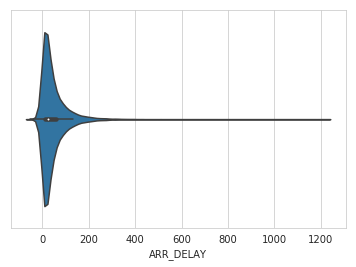

In [8]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
#ax.axes.set_xlim(0, 30)

In [9]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM flights.tzcorr
WHERE RAND() < 0.001

In [10]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,6127.000000,6150.000000
mean,3.567325,8.412033
std,36.472406,34.001889
min,-51.000000,-26.000000
25%,-13.000000,-5.000000
50%,-5.000000,-2.000000
75%,7.000000,6.000000
max,453.000000,466.000000


In [11]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
1,14.0,17.0,False
2,2.0,-9.0,True
5,52.0,59.0,False
6,65.0,36.0,False
8,255.0,265.0,False


(-50, 200)

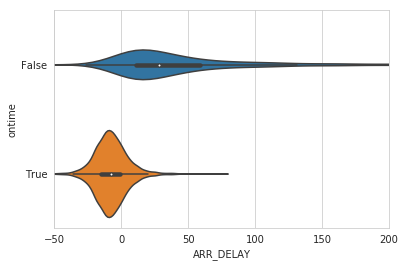

In [12]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

(-50, 50)

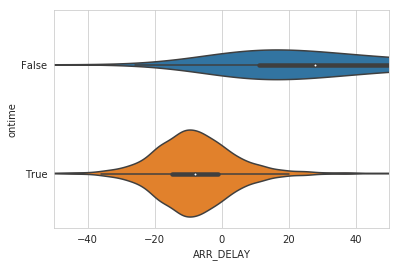

In [13]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50)

In [14]:
%%bigquery depdelay
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

In [15]:
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.978389,11.173010,509
1,-22.0,-23.323446,12.355125,708
2,-21.0,-22.549515,12.159491,1030
3,-20.0,-21.536148,12.062171,1563
4,-19.0,-20.628375,12.148920,2185


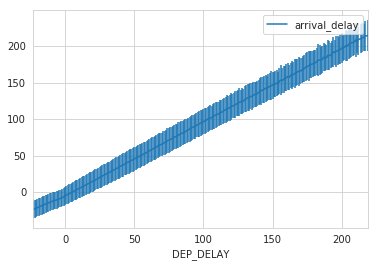

In [16]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


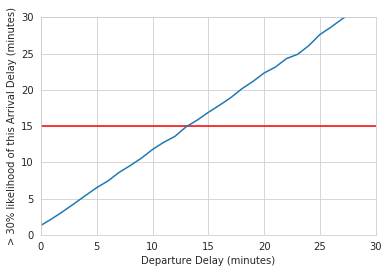

In [17]:
import matplotlib.pyplot as plt
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [18]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

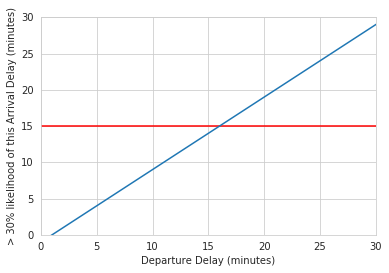

In [19]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [20]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

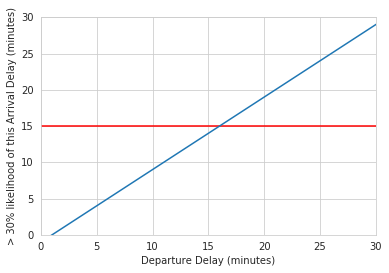

In [21]:
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

In [22]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [23]:
print(eval['correct_nocancel'] /
      (eval['correct_nocancel'] + eval['wrong_nocancel']))
print(eval['correct_cancel'] / 
      (eval['correct_cancel'] + eval['wrong_cancel']))

0    0.950439
dtype: float64
0    0.802476
dtype: float64


In [24]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1376187,71762,57699,234412


In [25]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )

In [26]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,8368,3146,7370,3157


In [27]:
print(eval['correct_nocancel'] / (eval['correct_nocancel'] + eval['wrong_nocancel']))
print(eval['correct_cancel'] / (eval['correct_cancel'] + eval['wrong_cancel']))

0    0.726767
dtype: float64
0    0.299896
dtype: float64


## Sending to a temporary table

In [28]:
!bq mk temp_dataset

Dataset 'cloud-training-demos:temp_dataset' successfully created.


In [29]:
%%bigquery
CREATE OR REPLACE TABLE temp_dataset.delays
AS

SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

""


In [30]:
!bq rm -f temp_dataset.delays
!bq rm -f temp_dataset

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.